In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import sys

In [2]:
r = 1./1e8
Ns = 1250
Nfft = Ns//2+1
Na = 50000000
Nr = Na//Ns
localized = True

In [3]:

ftsig = np.exp(1j*np.random.uniform(0,2*np.pi,Nfft))
if localized:
    x = np.arange(Nfft)
    ftsig *= np.exp(-(x-Nfft/2)**2/(2*(Nfft/20)**2))
    ftsig /= np.sqrt(ftsig.var())

sig = np.fft.irfft(ftsig)*np.sqrt(Ns)

print(sig.var())

1.0024227208435186


In [4]:
bigsig = np.hstack([sig]*Nr)

In [5]:
Pk = np.abs(np.fft.rfft(bigsig)**2)

Text(0, 0.5, 'Power')

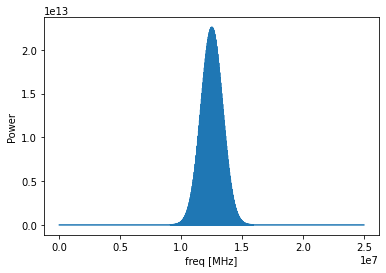

In [6]:
#plt.plot(np.arange(1,1000000)/1e6,Pk[1:1000000])
plt.plot(Pk)
plt.xlabel("freq [MHz]")
plt.ylabel("Power")

In [7]:
#let's oversample bigsig by a factor of 10
fft = np.fft.rfft(sig)

In [8]:
N = len(fft)-1
sigo = np.fft.irfft(np.hstack((fft,np.zeros(9*N))))*10
bigsigo = np.hstack([sigo]*(Nr+1))

Text(0, 0.5, 'amplitude')

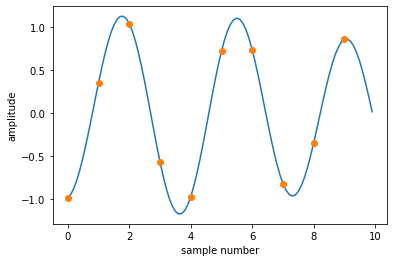

In [9]:
plt.plot(np.arange(100)/10,bigsigo[:100], label='interpolated band-limited waveform')
plt.plot(np.arange(0,100,10)/10,bigsig[:10],'o',label='original waveform')
plt.xlabel ('sample number')
plt.ylabel ('amplitude')

In [10]:
def gen_rec (drift, noise, L=None):
    if L is None:
        L+Nr*Ns
    bigsigdrift = bigsigo[(np.arange(0,10*L,10)*(1+drift*1e-6)+0.5).astype(int)]
    return (bigsigdrift+np.random.normal(0,noise,L)).reshape((-1,1000000//Ns,Ns)).mean(axis=1)

In [11]:
def shift (d,i):
    if (i==0):
        return d
    if (i==1):
        return np.hstack((d[1:],d[0]))
    if (i==-1):
        return np.hstack((d[-1],d[:-1]))

def coadd_drift (data, force_zero=False):
    cdata=data[0,:]
    drift = [0] 
    for mdata in data[1:]:
        pp = np.dot(shift(cdata,1),mdata)
        p0 = np.dot(cdata,mdata)
        pm = np.dot(shift(cdata,-1),mdata)
        if ((p0>pp) and (p0>pm)) or force_zero:
            drift.append(drift[-1])
            cdata = mdata+cdata
        elif (pm>pp) and (pm>p0):
            drift.append(drift[-1]-1)
            cdata = shift(cdata,-1)+mdata
        elif (pp>pm) and (pp>p0):
            drift.append(drift[-1]+1)
            cdata = shift(cdata,+1)+mdata
        else:
            print ('shit')
            stop()
    cdata/=len(data)
    sig = np.fft.rfft(cdata)*np.conj(ftsig)
    val = 1e100
    print ('getting drift')
    for phi in np.linspace(-0.6,0.6,60000):
        sigp = sig*np.exp(1j*phi*np.arange(len(sig)))
        loss = ((np.imag(sigp))**2)[1:-1].sum(axis=0)
        #print (phi,loss)
        if loss<val:
            best_phi = phi
            best_sig = sigp
            val=loss
            
    print (best_phi)
    sigr = np.real(best_sig)[1:-1].reshape((-1,26)).mean(axis=1)
    return drift,sigr,sig
        
        

In [12]:
res = []
for dB in [10,20,30,40]:
    noiserms = np.sqrt(10**(dB/10))
    print (dB,noiserms)
    a,b,x=coadd_drift(gen_rec(+0.0,noiserms,Nr*Ns))
    res.append(b)

10 3.1622776601683795
getting drift
-1.0000166669410504e-05
20 10.0
getting drift
1.0000166669410504e-05
30 31.622776601683793
getting drift
-1.0000166669410504e-05
40 100.0
getting drift
-1.0000166669410504e-05


In [13]:
fr=np.arange(1,25)*50/24

In [ ]:
for dB,r in zip([10,20,30,40],res):
    plt.plot(fr,r,label = f'{dB}dB below S+N')
    plt.ylim(30,45)
plt.xlabel('freq [MHz]')
plt.ylabel('Recovered response')
plt.legend()

In [ ]:
a,b,x=coadd_drift(gen_rec(+0.0,10,Nr*Ns))
plt.plot(fr,b,label = 'no clock drift')
a,b,x=coadd_drift(gen_rec(+0.2,10,Nr*Ns),force_zero=True)
plt.plot(fr,b,label = '+0.2ppm drift')
a,b,x=coadd_drift(gen_rec(-1.0,10,Nr*Ns),force_zero=True)
plt.plot(fr,b,label = '-1.0ppm drift')

plt.xlabel('freq [MHz]')
plt.ylabel('Recovered response')
plt.ylim(-10,45)
plt.legend()

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,10))
for drift in [0,0.2,0.4,0.6,0.8,1,1.5]:
    a,b,x=coadd_drift(gen_rec(+drift,10,Nr*Ns)) 
    ax1.plot(fr,b,label = f"+{drift}ppm drift" if drift!=0 else "no drift")
    ax2.plot(a)
ax1.set_xlabel('freq [MHz]')
ax1.set_ylabel('Recovered response')
ax1.set_ylim(-10,45)
ax1.legend()
ax2.set_xlabel('integration period')
ax2.set_ylabel('overal drift [samples]')
                    
            

getting drift
-0.05177086284771415
getting drift
-0.05177086284771415
getting drift
-0.04777079617993629
getting drift
-0.0513708561809364
getting drift
-0.04801080018000303


Text(0, 0.5, 'overal drift [samples]')

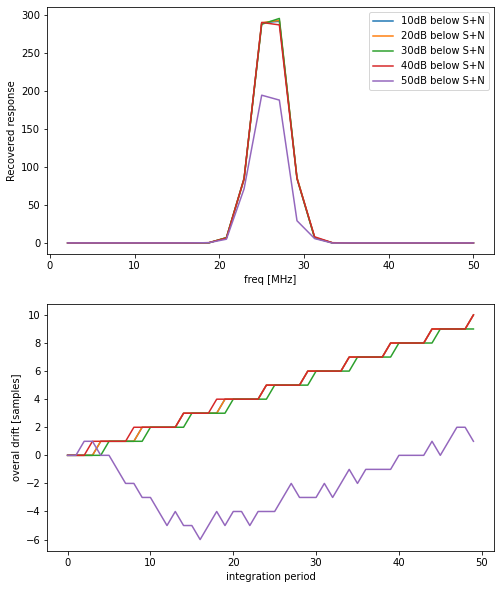

In [14]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,10))
for dB in [10,20,30,40,50]:
    noiserms = np.sqrt(10**(dB/10))
    a,b,x=coadd_drift(gen_rec(+0.2,noiserms,Nr*Ns)) 
    ax1.plot(fr,b,label = f'{dB}dB below S+N')
    ax2.plot(a)
ax1.set_xlabel('freq [MHz]')
ax1.set_ylabel('Recovered response')
#ax1.set_ylim(-10,45)
ax1.legend()
ax2.set_xlabel('integration period')
ax2.set_ylabel('overal drift [samples]')


In [ ]:
b.shape

In [ ]:
xp = x*np.exp(-0.5*1j*np.arange(len(x)))
plt.plot(np.real(xp))
plt.plot(np.imag(xp))

In [ ]:
(np.imag(xp)**2).sum()

In [ ]:
fx=np.linspace(0,50,1000)
lam = 3e8/(fx*1e6)
L=2
a=0.01
plt.plot(fx, 20*np.pi**2/(lam/L)**2,label='Re Z')
plt.plot(fx, 120*lam/(np.pi*L)*(np.log(L/(2*a))-1),label='Im z')
plt.semilogy()
plt.xlabel('freq [MHz]')
plt.ylabel('Impedance [Ohm]')


In [ ]:
np.log(L/(2*a))-1

In [ ]:
plt.plot(np.arange(1,1000000)/1e6,Pk[1:1000000],label='X pol')
plt.plot(np.arange(1,1000000)/1e6*0.88,Pk[1:1000000], label = 'Y pol')
plt.legend(loc='upper left')
plt.xlabel("freq [MHz]")
plt.ylabel("Power")